This notebook exists too experiment with the different methods seen to perform feature selection. Methods include:
- Statistical Measures
- PCA
- Wrapper Methods

In [1]:
%run "Parameter_Estimation.ipynb" #allowing access to parameters

100%|████████████████████████████████████████████████████████████████████████████████| 223/223 [00:03<00:00, 73.67it/s]


In [2]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.svm import SVC

In [3]:
health_state = allowed_patients.get_diagnoses()

encoded_health_state = [1 if label == 'Unhealthy' else -1 for label in health_state]

In [4]:
def get_balanced_accuracy(y_test, y_pred):
    """
    balanced accuracy....
    """
    num_healthy_true = np.sum([x=='Healthy' for x in y_test])
    num_unhealthy_true = len(y_test) - num_healthy_true
    count_healthy_accurate = 0
    count_unhealthy_accurate = 0
    for i in range(0, len(y_test)):
        if y_pred[i] == y_test[i] == 'Unhealthy':
            count_unhealthy_accurate +=1
        elif y_pred[i] == y_test[i] == 'Healthy':
            count_healthy_accurate +=1
    healthy_percentage = count_healthy_accurate/num_healthy_true
    unhealthy_percentage = count_unhealthy_accurate/num_unhealthy_true
    balanced_accuracy = (healthy_percentage + unhealthy_percentage) * 0.5
    return balanced_accuracy

def get_specificity(y_test, y_pred):
    """
    true negative rate
    """
    true_negative = 0
    false_positive = 0
    for i in range(0, len(y_test)):
        if y_pred[i] == y_test[i] == 'Healthy':
            true_negative += 1
        elif y_pred[i] != y_test[i] and y_test[i] == 'Healthy':
            false_positive += 1
    
    return true_negative / (true_negative+false_positive)
            
def get_f1_score(y_test, y_pred):
    """
    balance between precision and recall
    """
    true_positive = 0
    false_positive = 0
    false_negative = 0
    for i in range(0, len(y_test)):
        if y_pred[i] == y_test[i] == 'Unhealthy':
            true_positive += 1
        elif y_pred[i] != y_test[i] and y_test[i] == 'Healthy':
            false_positive += 1
        elif y_pred[i] != y_test[i] and y_test[i] == 'Unhealthy':
            false_negative += 1
    return (2*true_positive)/(2*true_positive+false_positive+false_negative)


def get_av_confusion_matrix(y_test, y_pred):
    av_confusion_mat = np.zeros(shape = (len(y_test), 2, 2))
    for i in range(0, len(y_test)):
        av_confusion_mat[i] = confusion_matrix(y_test[i], y_pred[i])
    return np.mean(av_confusion_mat, axis=0)

def scoring_function(model, X, y):
    """
    change to incorporate balanced accuracy 
    """
    
    y_pred = model.predict(X)
    y_test = y
    balanced_acc = get_balanced_accuracy(y_test, y_pred)
    #specificity = get_specificity(y_test, y_pred)
    f1 = get_f1_score(y_test, y_pred)
    
    
    return f1*0.7 + balanced_acc*0.3

## Parameter Selection

### correlation 
#### pmcc


In [5]:
from scipy.stats import pearsonr
import itertools

for key1, key2 in itertools.combinations(params.keys(), 2):
    corr, p_value = pearsonr(params[key1], params[key2])
    if p_value < 0.05:
        print(f"parameter {key1} and parameter {key2} are significantly correlated, p = {p_value}, corr = {corr}")


parameter rr_mean and parameter rr_std are significantly correlated, p = 0.000238443360345165, corr = 0.24370301196548685
parameter rr_mean and parameter RMSSD are significantly correlated, p = 0.0006189867955319877, corr = 0.22749680121375307
parameter rr_mean and parameter pNN50 are significantly correlated, p = 0.033465100891719654, corr = 0.14247166502037645
parameter rr_mean and parameter std are significantly correlated, p = 4.627133195304087e-10, corr = -0.4018144280421302
parameter rr_mean and parameter kurtosis are significantly correlated, p = 2.3144532569582885e-12, corr = 0.44718174643936054
parameter rr_mean and parameter hf are significantly correlated, p = 0.012325952282112045, corr = -0.16734828595993997
parameter rr_mean and parameter shannon_en are significantly correlated, p = 6.763833043118903e-06, corr = -0.29627865853054497
parameter rr_mean and parameter sd_ratio are significantly correlated, p = 9.587019537425523e-07, corr = -0.32119299513357796
parameter rr_std

#### wilcoxon 
compare the medians of two related samples or to compare repeated measurements of the same sample under different conditions. Should be used to test wether a parameter has provided a significant difference to the model.

compare above results with papers

## PCA
- loses the knowledge of features, less intuitive
- will experiment with it anyway

In [6]:
# Initialize the array
X = np.zeros((no_patients, 6))#need no. samples as rows, no. features as columns for machine learning analysis

# Populate the array with values from the dictionary
X[:, 0] = params['rr_mean']
X[:, 1] = params['kurtosis']
X[:, 2] = params['std']
X[:, 3] = params['power_ratio']
X[:, 4] = params['shannon_en']
X[:, 5] = params['skews']
    
#standardize data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

#set desired number of principle components
num_components = 2

#using sklearn PCA
pca = PCA(n_components=num_components)
X_pca = pca.fit_transform(X_scaled)

In [7]:
#using principle components to do ML

#splitting the data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(X_pca, health_state, test_size=0.3, stratify = health_state)

#init and train model, using radial basis functions
svm_classifier = SVC(kernel='rbf', gamma='scale', class_weight='balanced')  #'scale' normalises data, prevents overfitting
svm_classifier.fit(X_train, y_train)

#predictions
y_pred = svm_classifier.predict(X_test)

#evaluating accuracy of the model
accuracy = accuracy_score(y_test, y_pred)
print(y_pred)
print("Accuracy:", accuracy)

['Unhealthy' 'Healthy' 'Healthy' 'Unhealthy' 'Unhealthy' 'Unhealthy'
 'Unhealthy' 'Unhealthy' 'Healthy' 'Unhealthy' 'Unhealthy' 'Unhealthy'
 'Healthy' 'Unhealthy' 'Healthy' 'Unhealthy' 'Unhealthy' 'Unhealthy'
 'Healthy' 'Unhealthy' 'Unhealthy' 'Unhealthy' 'Unhealthy' 'Unhealthy'
 'Healthy' 'Healthy' 'Unhealthy' 'Healthy' 'Healthy' 'Unhealthy'
 'Unhealthy' 'Unhealthy' 'Healthy' 'Unhealthy' 'Unhealthy' 'Healthy'
 'Healthy' 'Unhealthy' 'Unhealthy' 'Unhealthy' 'Unhealthy' 'Unhealthy'
 'Healthy' 'Unhealthy' 'Healthy' 'Healthy' 'Unhealthy' 'Healthy'
 'Unhealthy' 'Unhealthy' 'Healthy' 'Unhealthy' 'Unhealthy' 'Unhealthy'
 'Healthy' 'Healthy' 'Unhealthy' 'Healthy' 'Unhealthy' 'Unhealthy'
 'Healthy' 'Unhealthy' 'Healthy' 'Healthy' 'Unhealthy' 'Healthy'
 'Unhealthy']
Accuracy: 0.6865671641791045


## Wrapper Methods:

These methods do feature selection whilst using the model

 - Forward Selection: Features are sequentially added to the model, starting with an empty set and adding the feature that improves model performance the most at each step.
 - Backward Elimination: Features are sequentially removed from the model, starting with the full set of features and removing the feature that decreases model performance the least at each step.
 - Recursive Feature Elimination (RFE): Features are recursively pruned based on the importance assigned to them by the model. Less important features are eliminated iteratively until the desired number of features is reached.

### RFE

In [8]:
from sklearn.feature_selection import RFE

# initializing parameter array
X = np.zeros((no_patients, 6))#need no. samples as rows, no. features as columns for machine learning analysis

X[:, 0] = params['rr_mean']
X[:, 1] = params['kurtosis']
X[:, 2] = params['shannon_en']
X[:, 3] = params['power_ratio']
X[:, 4] = params['std']
X[:, 5] = params['skews']

#splitting data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, health_state, test_size=0.3, stratify=health_state)

#initialise SVM -- have to use a linear kernel for rfe
svm = SVC(kernel="linear", class_weight='balanced')

#initialize RFE with the SVM model and desired number of feauters
rfe = RFE(estimator=svm, n_features_to_select=3)

rfe.fit(X_train, y_train)

RFE(estimator=SVC(class_weight='balanced', kernel='linear'),
    n_features_to_select=3)

In [9]:
print("Selected features:", rfe.support_)
print("Feature ranking:", rfe.ranking_)

Selected features: [False  True  True False  True False]
Feature ranking: [4 1 1 2 1 3]


In [10]:
# transform the dataset to include only the selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# train the SVM on the selected features
svm.fit(X_train_rfe, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test_rfe)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with selected features:", accuracy)

Accuracy with selected features: 0.5671641791044776


### RFE with CV

In [11]:
from sklearn.feature_selection import RFECV

#splitting data into test and train sets
X_train, X_test, y_train, y_test = train_test_split(X, health_state, test_size=0.3, stratify=health_state)

#initialise SVM 
svm = SVC(class_weight='balanced', kernel='linear')


#initialize RFE with the SVM model and desired number of feauters
rfe_cv = RFECV(estimator=rfe, min_features_to_select=2, scoring=scoring_function)

rfe.fit(X_train, y_train)

RFE(estimator=SVC(class_weight='balanced', kernel='linear'),
    n_features_to_select=3)

In [12]:
print("Selected features:", rfe.support_)
print("Feature ranking:", rfe.ranking_)

Selected features: [False False  True False  True  True]
Feature ranking: [4 3 1 2 1 1]


In [13]:
# transform the dataset to include only the selected features
X_train_rfe = rfe.transform(X_train)
X_test_rfe = rfe.transform(X_test)

# train the SVM on the selected features
svm.fit(X_train_rfe, y_train)

# Make predictions on the test set
y_pred = svm.predict(X_test_rfe)

# Evaluate the model performance
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy with selected features:", accuracy)

Accuracy with selected features: 0.5223880597014925


### Forward/Backward Elimination

May be slower than RFE but does not need to have coefficients i.e. a linear kernel.

In [14]:
from sklearn.feature_selection import SequentialFeatureSelector 

svm_rbf = SVC(class_weight='balanced')

SFS_forward = SequentialFeatureSelector(estimator=svm_rbf, scoring=scoring_function, cv=3)

SFS_forward.fit(X_train, y_train)

SFS_forward.get_support()

array([False,  True,  True, False,  True, False])

In [15]:
SFS_backward = SequentialFeatureSelector(estimator=svm_rbf, tol=-1, direction='backward', scoring=scoring_function)

SFS_backward.fit(X_train, y_train)

SFS_forward.get_support()

array([False,  True,  True, False,  True, False])

In [16]:
#these agree but disagrees with RFE???

## Embedded Methods:

Also done whilst using the model

- Regularization: Techniques like LASSO (L1 regularization) and Ridge (L2 regularization) penalize the magnitude of feature coefficients, forcing less important features to have coefficients close to zero.

Selected feature indices: [0 1 2 3 5]
Feature importance: [5.65476498e-04 3.02560295e-05 4.08241126e-01 3.58472704e-02
 1.28235068e-01]


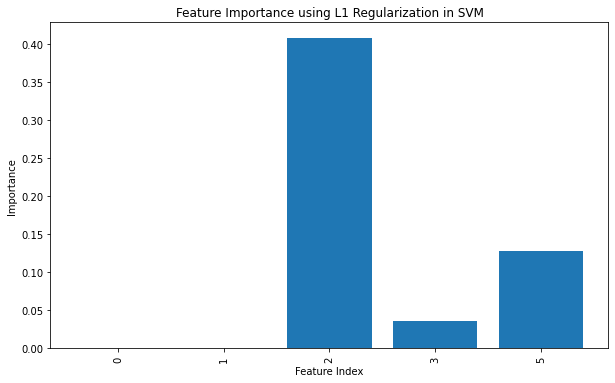

In [17]:
#try do this properly
#LASSO/Ridge Regression

from sklearn.svm import LinearSVC
from sklearn.feature_selection import SelectFromModel

# Fit the model using L1 regularization
model = LinearSVC(C=1.0, penalty='l1', dual=False, class_weight='balanced').fit(X_train, y_train)

# Get feature importance (coefficients)
feature_importance = np.abs(model.coef_[0])

# Select features with non-zero coefficients
model_selector = SelectFromModel(model, prefit=True)
X_train_selected = model_selector.transform(X_train)
X_test_selected = model_selector.transform(X_test)

# Get indices of selected features
selected_indices = np.where(feature_importance > 0)[0]

# Print selected feature indices and their importance
print("Selected feature indices:", selected_indices)
print("Feature importance:", feature_importance[selected_indices])

# Plot feature importance
plt.figure(figsize=(10, 6))
plt.bar(range(len(selected_indices)), feature_importance[selected_indices])
plt.xticks(range(len(selected_indices)), selected_indices, rotation=90)
plt.xlabel('Feature Index')
plt.ylabel('Importance')
plt.title('Feature Importance using L1 Regularization in SVM')
plt.show()

# If you want to use the selected features for another model
# You can use X_train_selected and X_test_selected

